In [1]:
# to monitor the progress
from tqdm import tqdm
import time
# basic dependency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Class for client
class client_base:
    def __init__(self, client_requirement=[0,0,0]):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        if num==0:
            print(num)
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
        if client_requirement[0] == 0 or client_requirement[1] == 0 or client_requirement[2] == 0:
            print('Some zeros appear!')
            print(client_requirement)     
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r

In [3]:
client = client_base()
def compute_total_fee(x1,x2,x3):
    offer = (x1,x2,x3)
    _,_,_,total_fee_new = client.related_fee(offer)
    return total_fee_new

# X

In [4]:
df_x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_x_test['requirement_total_fee'] = df_x_test.apply(lambda x: compute_total_fee(x['vcpu'],x['ram'],x['volume']), axis=1)
x_fee_array = np.array(df_x_test['requirement_total_fee'].tolist())

In [5]:
df_x_test

,vcpu,ram,volume,requirement_total_fee
0,5,25,400,7.750
1,7,35,220,7.350
2,7,54,400,9.600
3,7,56,320,9.300
4,7,56,520,10.300
...,...,...,...,...
195,47,122,660,16.200
196,47,138,700,16.800
197,47,164,720,17.550
198,48,111,820,16.775


In [6]:
x_vcpu_array = np.array(df_x_test['vcpu'].tolist())
x_ram_array = np.array(df_x_test['ram'].tolist())
x_storage_array = np.array(df_x_test['volume'].tolist())

In [7]:
df_x_test[190:200]

,vcpu,ram,volume,requirement_total_fee
190,44,159,470,16.025
191,45,97,730,15.825
192,45,129,660,16.275
193,45,131,860,17.325
194,46,156,840,17.900
195,47,122,660,16.200
196,47,138,700,16.800
197,47,164,720,17.550
198,48,111,820,16.775
199,48,144,690,16.950


# Different versions

In [8]:
# Normalization function
vcpu_scaler = lambda x : (x-1)/(90-1)
ram_scaler = lambda x : (x-1)/(180-1)
volume_scaler = lambda x : (x-1)/(900-1)

## v4

In [9]:
df_v4_y_test = pd.read_csv('./data/offer_ML/v4_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v4_y_test_predict = pd.read_csv('./data/offer_ML/v4_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v4_y_test['label_total_fee'] = df_v4_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v4_y_test_predict['predict_total_fee'] = df_v4_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v4_label_fee_array = np.array(df_v4_y_test['label_total_fee'].tolist())
v4_predict_fee_array = np.array(df_v4_y_test_predict['predict_total_fee'].tolist())

v4_label_fee_ratio_array = v4_label_fee_array/x_fee_array
v4_predict_fee_ratio_array = v4_predict_fee_array/x_fee_array

In [10]:
v4_label_vcpu_array = np.array(df_v4_y_test['final_vcpu'].tolist())
v4_label_ram_array = np.array(df_v4_y_test['final_ram'].tolist())
v4_label_storage_array = np.array(df_v4_y_test['final_volume'].tolist())

v4_label_vcpu_ratio = v4_label_vcpu_array/x_vcpu_array 
v4_label_ram_ratio = v4_label_ram_array/x_ram_array
v4_label_storage_ratio = v4_label_storage_array/x_storage_array

v4_predict_vcpu_array = np.array(df_v4_y_test_predict['predict_vcpu'].tolist())
v4_predict_ram_array = np.array(df_v4_y_test_predict['predict_ram'].tolist())
v4_predict_storage_array = np.array(df_v4_y_test_predict['predict_volume'].tolist())

v4_predict_vcpu_ratio = v4_predict_vcpu_array/x_vcpu_array 
v4_predict_ram_ratio = v4_predict_ram_array/x_ram_array
v4_predict_storage_ratio = v4_predict_storage_array/x_storage_array

In [11]:
new_df_v4_y_test = pd.DataFrame(df_v4_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v4_y_test_predict = pd.DataFrame(df_v4_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v4_y_test[['final_vcpu']] = new_df_v4_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v4_y_test[['final_ram']] = new_df_v4_y_test[['final_ram']].apply(ram_scaler)
new_df_v4_y_test[['final_volume']] = new_df_v4_y_test[['final_volume']].apply(volume_scaler)

new_df_v4_y_test_predict[['predict_vcpu']] = new_df_v4_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v4_y_test_predict[['predict_ram']] = new_df_v4_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v4_y_test_predict[['predict_volume']] = new_df_v4_y_test_predict[['predict_volume']].apply(volume_scaler)

v4_label = (torch.tensor(new_df_v4_y_test.values)).float()
v4_predict = (torch.tensor(new_df_v4_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v4_label,v4_predict)

tensor(0.0008)

In [12]:
print('VCPU')
print('V4',criterion(v4_label[:,0],v4_predict[:,0]))
print('RAM')
print('V4',criterion(v4_label[:,1],v4_predict[:,1]))
print('Storage')
print('V4',criterion(v4_label[:,2],v4_predict[:,2]))

VCPU
V4 tensor(0.0011)
RAM
V4 tensor(0.0006)
Storage
V4 tensor(0.0006)


## v3

In [13]:
df_v3_y_test = pd.read_csv('./data/offer_ML/v3_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v3_y_test_predict = pd.read_csv('./data/offer_ML/v3_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v3_y_test['label_total_fee'] = df_v3_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v3_y_test_predict['predict_total_fee'] = df_v3_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v3_label_fee_array = np.array(df_v3_y_test['label_total_fee'].tolist())
v3_predict_fee_array = np.array(df_v3_y_test_predict['predict_total_fee'].tolist())

v3_label_fee_ratio_array = v3_label_fee_array/x_fee_array
v3_predict_fee_ratio_array = v3_predict_fee_array/x_fee_array

In [14]:
v3_label_vcpu_array = np.array(df_v3_y_test['final_vcpu'].tolist())
v3_label_ram_array = np.array(df_v3_y_test['final_ram'].tolist())
v3_label_storage_array = np.array(df_v3_y_test['final_volume'].tolist())

v3_label_vcpu_ratio = v3_label_vcpu_array/x_vcpu_array 
v3_label_ram_ratio = v3_label_ram_array/x_ram_array
v3_label_storage_ratio = v3_label_storage_array/x_storage_array

v3_predict_vcpu_array = np.array(df_v3_y_test_predict['predict_vcpu'].tolist())
v3_predict_ram_array = np.array(df_v3_y_test_predict['predict_ram'].tolist())
v3_predict_storage_array = np.array(df_v3_y_test_predict['predict_volume'].tolist())

v3_predict_vcpu_ratio = v3_predict_vcpu_array/x_vcpu_array 
v3_predict_ram_ratio = v3_predict_ram_array/x_ram_array
v3_predict_storage_ratio = v3_predict_storage_array/x_storage_array

In [15]:
new_df_v3_y_test = pd.DataFrame(df_v3_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v3_y_test_predict = pd.DataFrame(df_v3_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v3_y_test[['final_vcpu']] = new_df_v3_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test[['final_ram']] = new_df_v3_y_test[['final_ram']].apply(ram_scaler)
new_df_v3_y_test[['final_volume']] = new_df_v3_y_test[['final_volume']].apply(volume_scaler)

new_df_v3_y_test_predict[['predict_vcpu']] = new_df_v3_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test_predict[['predict_ram']] = new_df_v3_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v3_y_test_predict[['predict_volume']] = new_df_v3_y_test_predict[['predict_volume']].apply(volume_scaler)

v3_label = (torch.tensor(new_df_v3_y_test.values)).float()
v3_predict = (torch.tensor(new_df_v3_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v3_label,v3_predict)

tensor(0.0008)

In [16]:
print('VCPU')
print('V3',criterion(v3_label[:,0],v3_predict[:,0]))
print('RAM')
print('V3',criterion(v3_label[:,1],v3_predict[:,1]))
print('Storage')
print('V3',criterion(v3_label[:,2],v3_predict[:,2]))

VCPU
V3 tensor(0.0011)
RAM
V3 tensor(0.0007)
Storage
V3 tensor(0.0006)


## v2

In [17]:
df_v2_y_test = pd.read_csv('./data/offer_ML/v2_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v2_y_test_predict = pd.read_csv('./data/offer_ML/v2_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v2_y_test['label_total_fee'] = df_v2_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v2_y_test_predict['predict_total_fee'] = df_v2_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v2_label_fee_array = np.array(df_v2_y_test['label_total_fee'].tolist())
v2_predict_fee_array = np.array(df_v2_y_test_predict['predict_total_fee'].tolist())

v2_label_fee_ratio_array = v2_label_fee_array/x_fee_array
v2_predict_fee_ratio_array = v2_predict_fee_array/x_fee_array

In [18]:
v2_label_vcpu_array = np.array(df_v2_y_test['final_vcpu'].tolist())
v2_label_ram_array = np.array(df_v2_y_test['final_ram'].tolist())
v2_label_storage_array = np.array(df_v2_y_test['final_volume'].tolist())

v2_label_vcpu_ratio = v2_label_vcpu_array/x_vcpu_array 
v2_label_ram_ratio = v2_label_ram_array/x_ram_array
v2_label_storage_ratio = v2_label_storage_array/x_storage_array

v2_predict_vcpu_array = np.array(df_v2_y_test_predict['predict_vcpu'].tolist())
v2_predict_ram_array = np.array(df_v2_y_test_predict['predict_ram'].tolist())
v2_predict_storage_array = np.array(df_v2_y_test_predict['predict_volume'].tolist())

v2_predict_vcpu_ratio = v2_predict_vcpu_array/x_vcpu_array 
v2_predict_ram_ratio = v2_predict_ram_array/x_ram_array
v2_predict_storage_ratio = v2_predict_storage_array/x_storage_array

In [19]:
new_df_v2_y_test = pd.DataFrame(df_v2_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v2_y_test_predict = pd.DataFrame(df_v2_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v2_y_test[['final_vcpu']] = new_df_v2_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v2_y_test[['final_ram']] = new_df_v2_y_test[['final_ram']].apply(ram_scaler)
new_df_v2_y_test[['final_volume']] = new_df_v2_y_test[['final_volume']].apply(volume_scaler)

new_df_v2_y_test_predict[['predict_vcpu']] = new_df_v2_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v2_y_test_predict[['predict_ram']] = new_df_v2_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v2_y_test_predict[['predict_volume']] = new_df_v2_y_test_predict[['predict_volume']].apply(volume_scaler)

v2_label = (torch.tensor(new_df_v2_y_test.values)).float()
v2_predict = (torch.tensor(new_df_v2_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v2_label,v2_predict)

tensor(0.0007)

In [20]:
print('VCPU')
print('V2',criterion(v2_label[:,0],v2_predict[:,0]))
print('RAM')
print('V2',criterion(v2_label[:,1],v2_predict[:,1]))
print('Storage')
print('V2',criterion(v2_label[:,2],v2_predict[:,2]))

VCPU
V2 tensor(0.0007)
RAM
V2 tensor(0.0011)
Storage
V2 tensor(0.0003)


## v1

In [21]:
df_v1_y_test = pd.read_csv('./data/offer_ML/v1_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v1_y_test_predict = pd.read_csv('./data/offer_ML/v1_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v1_y_test['label_total_fee'] = df_v1_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v1_y_test_predict['predict_total_fee'] = df_v1_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v1_label_fee_array = np.array(df_v1_y_test['label_total_fee'].tolist())
v1_predict_fee_array = np.array(df_v1_y_test_predict['predict_total_fee'].tolist())

v1_label_fee_ratio_array = v1_label_fee_array/x_fee_array
v1_predict_fee_ratio_array = v1_predict_fee_array/x_fee_array

In [22]:
v1_label_vcpu_array = np.array(df_v1_y_test['final_vcpu'].tolist())
v1_label_ram_array = np.array(df_v1_y_test['final_ram'].tolist())
v1_label_storage_array = np.array(df_v1_y_test['final_volume'].tolist())

v1_label_vcpu_ratio = v1_label_vcpu_array/x_vcpu_array 
v1_label_ram_ratio = v1_label_ram_array/x_ram_array
v1_label_storage_ratio = v1_label_storage_array/x_storage_array

v1_predict_vcpu_array = np.array(df_v1_y_test_predict['predict_vcpu'].tolist())
v1_predict_ram_array = np.array(df_v1_y_test_predict['predict_ram'].tolist())
v1_predict_storage_array = np.array(df_v1_y_test_predict['predict_volume'].tolist())

v1_predict_vcpu_ratio = v1_predict_vcpu_array/x_vcpu_array 
v1_predict_ram_ratio = v1_predict_ram_array/x_ram_array
v1_predict_storage_ratio = v1_predict_storage_array/x_storage_array

In [23]:
new_df_v1_y_test = pd.DataFrame(df_v1_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v1_y_test_predict = pd.DataFrame(df_v1_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v1_y_test[['final_vcpu']] = new_df_v1_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v1_y_test[['final_ram']] = new_df_v1_y_test[['final_ram']].apply(ram_scaler)
new_df_v1_y_test[['final_volume']] = new_df_v1_y_test[['final_volume']].apply(volume_scaler)

new_df_v1_y_test_predict[['predict_vcpu']] = new_df_v1_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v1_y_test_predict[['predict_ram']] = new_df_v1_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v1_y_test_predict[['predict_volume']] = new_df_v1_y_test_predict[['predict_volume']].apply(volume_scaler)

v1_label = (torch.tensor(new_df_v1_y_test.values)).float()
v1_predict = (torch.tensor(new_df_v1_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v1_label,v1_predict)

tensor(0.0006)

In [24]:
print('VCPU')
print('V1',criterion(v1_label[:,0],v1_predict[:,0]))
print('RAM')
print('V1',criterion(v1_label[:,1],v1_predict[:,1]))
print('Storage')
print('V1',criterion(v1_label[:,2],v1_predict[:,2]))

VCPU
V1 tensor(0.0009)
RAM
V1 tensor(0.0004)
Storage
V1 tensor(0.0005)


## v0

In [25]:
df_v0_y_test = pd.read_csv('./data/offer_ML/v0_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v0_y_test_predict = pd.read_csv('./data/offer_ML/v0_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v0_y_test['label_total_fee'] = df_v0_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v0_y_test_predict['predict_total_fee'] = df_v0_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v0_label_fee_array = np.array(df_v0_y_test['label_total_fee'].tolist())
v0_predict_fee_array = np.array(df_v0_y_test_predict['predict_total_fee'].tolist())

v0_label_fee_ratio_array = v0_label_fee_array/x_fee_array
v0_predict_fee_ratio_array = v0_predict_fee_array/x_fee_array

In [26]:
v0_label_vcpu_array = np.array(df_v0_y_test['final_vcpu'].tolist())
v0_label_ram_array = np.array(df_v0_y_test['final_ram'].tolist())
v0_label_storage_array = np.array(df_v0_y_test['final_volume'].tolist())

v0_label_vcpu_ratio = v0_label_vcpu_array/x_vcpu_array 
v0_label_ram_ratio = v0_label_ram_array/x_ram_array
v0_label_storage_ratio = v0_label_storage_array/x_storage_array

v0_predict_vcpu_array = np.array(df_v0_y_test_predict['predict_vcpu'].tolist())
v0_predict_ram_array = np.array(df_v0_y_test_predict['predict_ram'].tolist())
v0_predict_storage_array = np.array(df_v0_y_test_predict['predict_volume'].tolist())

v0_predict_vcpu_ratio = v0_predict_vcpu_array/x_vcpu_array 
v0_predict_ram_ratio = v0_predict_ram_array/x_ram_array
v0_predict_storage_ratio = v0_predict_storage_array/x_storage_array

In [27]:
new_df_v0_y_test = pd.DataFrame(df_v0_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v0_y_test_predict = pd.DataFrame(df_v0_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v0_y_test[['final_vcpu']] = new_df_v0_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v0_y_test[['final_ram']] = new_df_v0_y_test[['final_ram']].apply(ram_scaler)
new_df_v0_y_test[['final_volume']] = new_df_v0_y_test[['final_volume']].apply(volume_scaler)

new_df_v0_y_test_predict[['predict_vcpu']] = new_df_v0_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v0_y_test_predict[['predict_ram']] = new_df_v0_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v0_y_test_predict[['predict_volume']] = new_df_v0_y_test_predict[['predict_volume']].apply(volume_scaler)

v0_label = (torch.tensor(new_df_v0_y_test.values)).float()
v0_predict = (torch.tensor(new_df_v0_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v0_label,v0_predict)

tensor(0.0007)

In [28]:
print('VCPU')
print('V0',criterion(v0_label[:,0],v0_predict[:,0]))
print('RAM')
print('V0',criterion(v0_label[:,1],v0_predict[:,1]))
print('Storage')
print('V0',criterion(v0_label[:,2],v0_predict[:,2]))

VCPU
V0 tensor(0.0008)
RAM
V0 tensor(0.0006)
Storage
V0 tensor(0.0007)


# v00

In [29]:
df_v00_y_test = pd.read_csv('./data/offer_ML/v00_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v00_y_test_predict = pd.read_csv('./data/offer_ML/v00_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v00_y_test['label_total_fee'] = df_v00_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v00_y_test_predict['predict_total_fee'] = df_v00_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v00_label_fee_array = np.array(df_v00_y_test['label_total_fee'].tolist())
v00_predict_fee_array = np.array(df_v00_y_test_predict['predict_total_fee'].tolist())

v00_label_fee_ratio_array = v00_label_fee_array/x_fee_array
v00_predict_fee_ratio_array = v00_predict_fee_array/x_fee_array

In [30]:
v00_label_vcpu_array = np.array(df_v00_y_test['final_vcpu'].tolist())
v00_label_ram_array = np.array(df_v00_y_test['final_ram'].tolist())
v00_label_storage_array = np.array(df_v00_y_test['final_volume'].tolist())

v00_label_vcpu_ratio = v00_label_vcpu_array/x_vcpu_array 
v00_label_ram_ratio = v00_label_ram_array/x_ram_array
v00_label_storage_ratio = v00_label_storage_array/x_storage_array

v00_predict_vcpu_array = np.array(df_v00_y_test_predict['predict_vcpu'].tolist())
v00_predict_ram_array = np.array(df_v00_y_test_predict['predict_ram'].tolist())
v00_predict_storage_array = np.array(df_v00_y_test_predict['predict_volume'].tolist())

v00_predict_vcpu_ratio = v00_predict_vcpu_array/x_vcpu_array 
v00_predict_ram_ratio = v00_predict_ram_array/x_ram_array
v00_predict_storage_ratio = v00_predict_storage_array/x_storage_array

In [31]:
new_df_v00_y_test = pd.DataFrame(df_v00_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v00_y_test_predict = pd.DataFrame(df_v00_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v00_y_test[['final_vcpu']] = new_df_v00_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v00_y_test[['final_ram']] = new_df_v00_y_test[['final_ram']].apply(ram_scaler)
new_df_v00_y_test[['final_volume']] = new_df_v00_y_test[['final_volume']].apply(volume_scaler)

new_df_v00_y_test_predict[['predict_vcpu']] = new_df_v00_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v00_y_test_predict[['predict_ram']] = new_df_v00_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v00_y_test_predict[['predict_volume']] = new_df_v00_y_test_predict[['predict_volume']].apply(volume_scaler)

v00_label = (torch.tensor(new_df_v00_y_test.values)).float()
v00_predict = (torch.tensor(new_df_v00_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v00_label,v00_predict)

tensor(0.0008)

In [32]:
print('VCPU')
print('V00',criterion(v00_label[:,0],v00_predict[:,0]))
print('RAM')
print('V00',criterion(v00_label[:,1],v00_predict[:,1]))
print('Storage')
print('V00',criterion(v00_label[:,2],v00_predict[:,2]))

VCPU
V00 tensor(0.0008)
RAM
V00 tensor(0.0010)
Storage
V00 tensor(0.0006)


# Plot

In [57]:
plt.rcParams.update({'font.size': 12})

# Different cases (Baseline vs. Case 1 vs. Case 2)

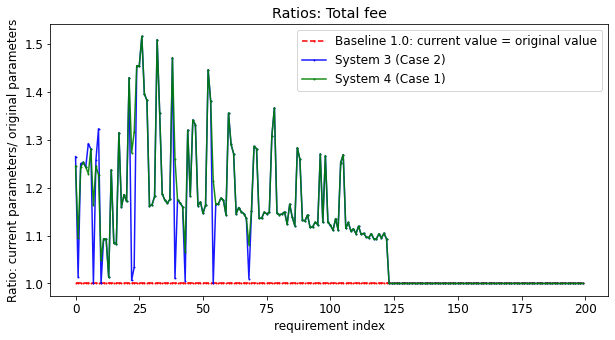

In [58]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r00 = v00_label_fee_ratio_array
r3 = v3_label_fee_ratio_array
r4 = v4_label_fee_ratio_array

plt.title('Ratios: Total fee')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1 ,label='Baseline 1.0: current value = original value') 
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 3 (Case 2)')
plt.plot(x, r00, marker='o', markersize=1, alpha = 0.9, color='green',label='System 4 (Case 1)')
#plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='orange',label='Case 3')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_case12_fee.jpg')
plt.show()  # 显示折线图

1.859530425278661
1.856871344979875
1.8104016112822001


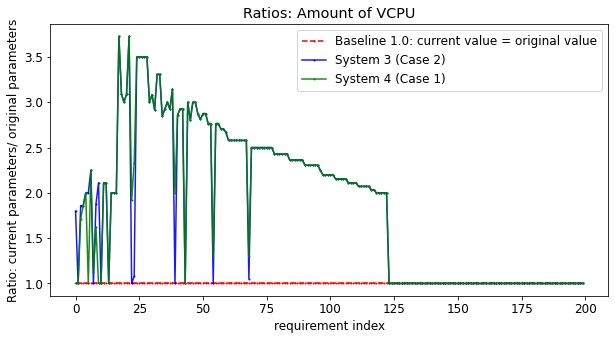

In [64]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r00 = v00_label_vcpu_ratio
r3 = v3_label_vcpu_ratio
r4 = v4_label_vcpu_ratio

plt.title('Ratios: Amount of VCPU')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 3 (Case 2)')
plt.plot(x, r00, marker='o', markersize=1, alpha = 0.9, color='green',label='System 4 (Case 1)')
#plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='orange',label='Case 3')

m00 = np.mean(v00_label_vcpu_ratio)
m3 = np.mean(v3_label_vcpu_ratio)
m4 = np.mean(v4_label_vcpu_ratio)
print(m00)
print(m3)
print(m4)

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_case12_vcpu.jpg')
plt.show()  # 显示折线图

1.150080226592417
1.1346891553207095


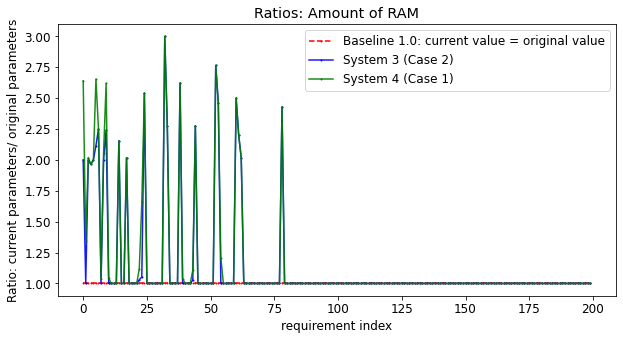

In [65]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r00 = v00_label_ram_ratio
r3 = v3_label_ram_ratio
#r4 = v4_label_ram_ratio

plt.title('Ratios: Amount of RAM')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 3 (Case 2)')
plt.plot(x, r00, marker='o', markersize=1, alpha = 0.9, color='green',label='System 4 (Case 1)')
#plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='blue',label='Case 3')

m00 = np.mean(v00_label_ram_ratio)
m3 = np.mean(v3_label_ram_ratio)
#m4 = np.mean(v4_label_ram_ratio)
print(m00)
print(m3)
#print(m4)

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_case12_ram.jpg')
plt.show()  # 显示折线图

1.107418982723368
1.093706252860638
1.088602913607299


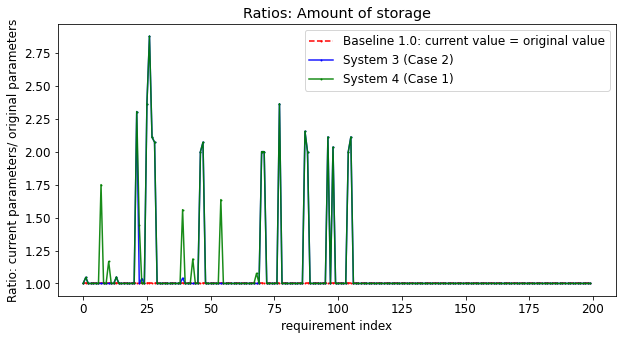

In [66]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r00 = v00_label_storage_ratio
r3 = v3_label_storage_ratio
r4 = v4_label_storage_ratio

plt.title('Ratios: Amount of storage')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 3 (Case 2)')
plt.plot(x, r00, marker='o', markersize=1, alpha = 0.9, color='green',label='System 4 (Case 1)')
#plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='blue',label='Case 3')

m00 = np.mean(v00_label_storage_ratio)
m3 = np.mean(v3_label_storage_ratio)
m4 = np.mean(v4_label_storage_ratio)
print(m00)
print(m3)
print(m4)

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_case12_storage.jpg')
plt.show()  # 显示折线图

# Different membership functions (Triangular MF vs. Gaussion MF )

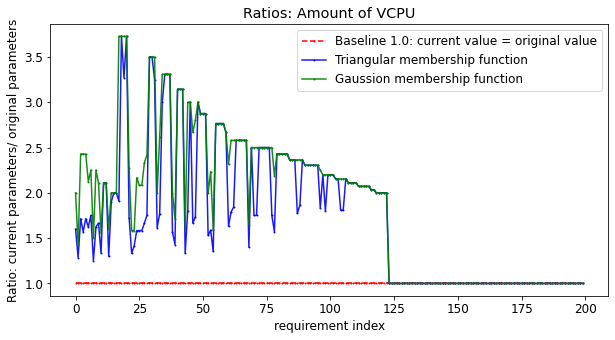

In [67]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_vcpu_ratio
r2 = v2_label_vcpu_ratio

plt.title('Ratios: Amount of VCPU')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='Triangular membership function')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='Gaussion membership function')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_mf_vcpu.jpg')
plt.show()  # 显示折线图

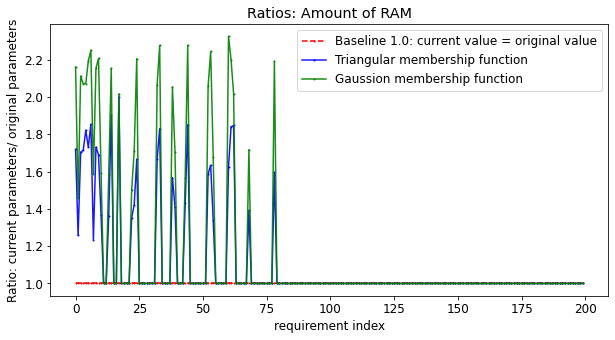

In [68]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_ram_ratio
r2 = v2_label_ram_ratio

plt.title('Ratios: Amount of RAM')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='Triangular membership function')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='Gaussion membership function')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_mf_ram.jpg')
plt.show()  # 显示折线图

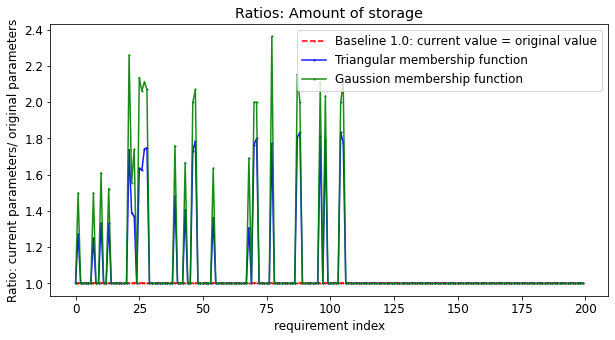

In [69]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_storage_ratio
r2 = v2_label_storage_ratio

plt.title('Ratios: Amount of storage')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='Triangular membership function')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='Gaussion membership function')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_mf_storage.jpg')
plt.show()  # 显示折线图

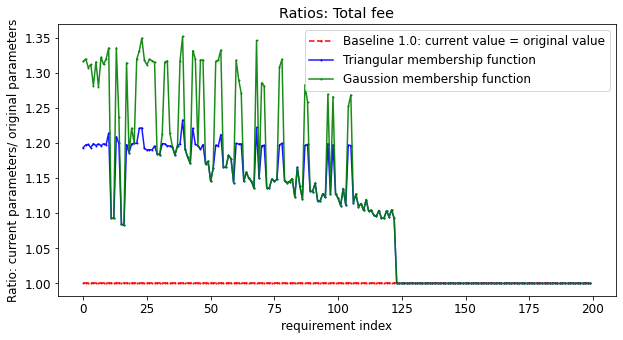

In [70]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_fee_ratio_array
r2 = v2_label_fee_ratio_array

plt.title('Ratios: Total fee')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='Triangular membership function')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='Gaussion membership function')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_mf_fee.jpg')
plt.show()  # 显示折线图

# Different fuzzy rule sets (7-rule vs. 30-rule )

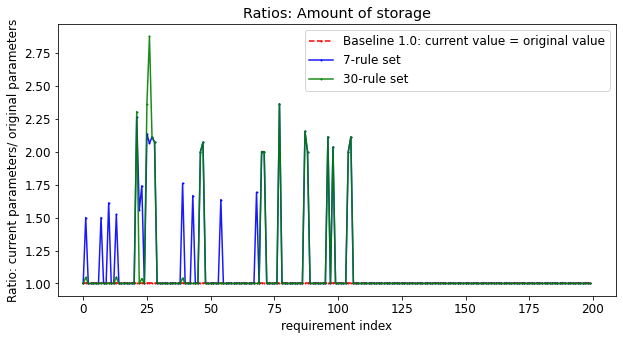

In [72]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r2 = v2_label_storage_ratio
r3 = v3_label_storage_ratio

plt.title('Ratios: Amount of storage')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='blue',label='7-rule set')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='green',label='30-rule set')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_rule_storage.jpg')
plt.show()  # 显示折线图

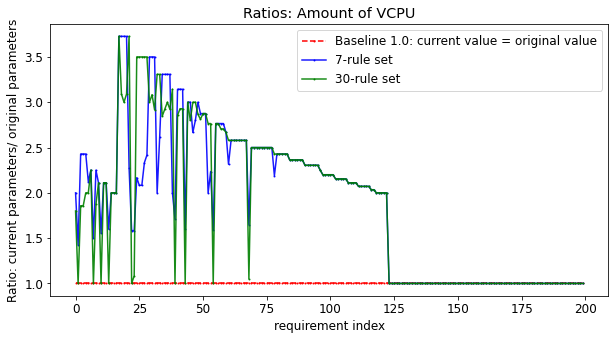

In [73]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r2 = v2_label_vcpu_ratio
r3 = v3_label_vcpu_ratio

plt.title('Ratios: Amount of VCPU')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='blue',label='7-rule set')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='green',label='30-rule set')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_rule_vcpu.jpg')
plt.show()  # 显示折线图

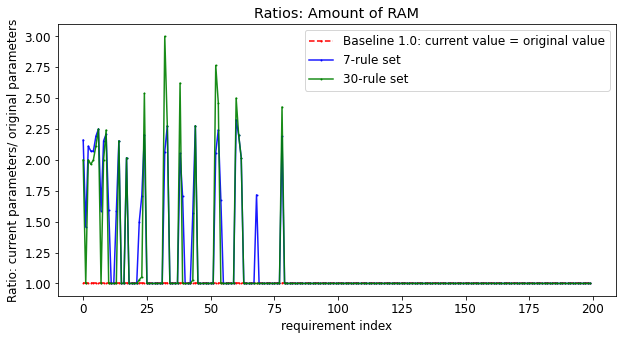

In [74]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r2 = v2_label_ram_ratio
r3 = v3_label_ram_ratio

plt.title('Ratios: Amount of RAM')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='blue',label='7-rule set')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='green',label='30-rule set')
'''
m1 = np.mean(v1_label_ram_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_ram_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_rule_ram.jpg')
plt.show()  # 显示折线图

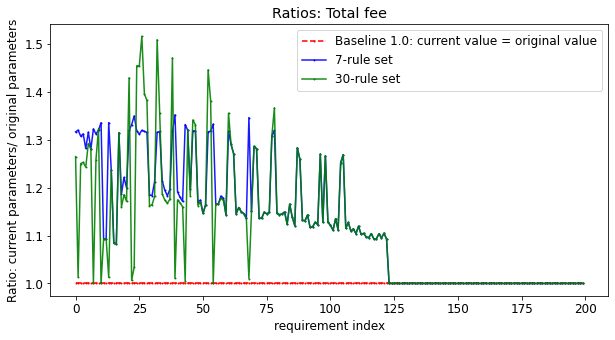

In [75]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r2 = v2_label_fee_ratio_array
r3 = v3_label_fee_ratio_array

plt.title('Ratios: Total fee')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='blue',label='7-rule set')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='green',label='30-rule set')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_rule_fee.jpg')
plt.show()  # 显示折线图